## Start Feature Extraction from the collected Dataset

In [2]:
import os
import pandas as pd
import librosa

import numpy as np
import matplotlib.pyplot as plt

os.chdir('../')

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
from plot_helper import PlotHelp
from real_time_inference import RecordThread

In [5]:
file_path = "data//external//processed//"
meta_data = pd.read_csv("data//meta_data.csv")

In [6]:
## if this doesn't hold .. some deep problem we gotta fix my myan
assert all(meta_data.start_time.isna() == meta_data.end_time.isna())

In [7]:
meta_data['label'] = ~meta_data.start_time.isna()
meta_data['label'] = meta_data['label'].astype(int) 

In [8]:
meta_data

,filename,start_time,end_time,label
0,0.wav,NaN,NaN,0
1,1.wav,2060.135706,2768.135706,1
2,2.wav,5898.247361,6653.247361,1
3,3.wav,NaN,NaN,0
4,4.wav,NaN,NaN,0
...,...,...,...,...
1995,1995.wav,NaN,NaN,0
1996,1996.wav,NaN,NaN,0
1997,1997.wav,141.648704,814.648704,1
1998,1998.wav,1940.152564,2683.152564,1


In [20]:
def get_melspectrogram_db(file_path, sr=44100, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [61]:
def norm_spec(spec):
    return (spec - spec.min()) / (spec.max() - spec.min())

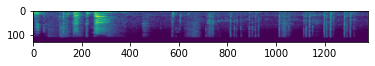

In [63]:
plt.imshow(norm_spec( get_melspectrogram_db( 'inference_1.wav' ) ))

In [21]:
plot_help = PlotHelp()

## Check the Traning Example Visually  

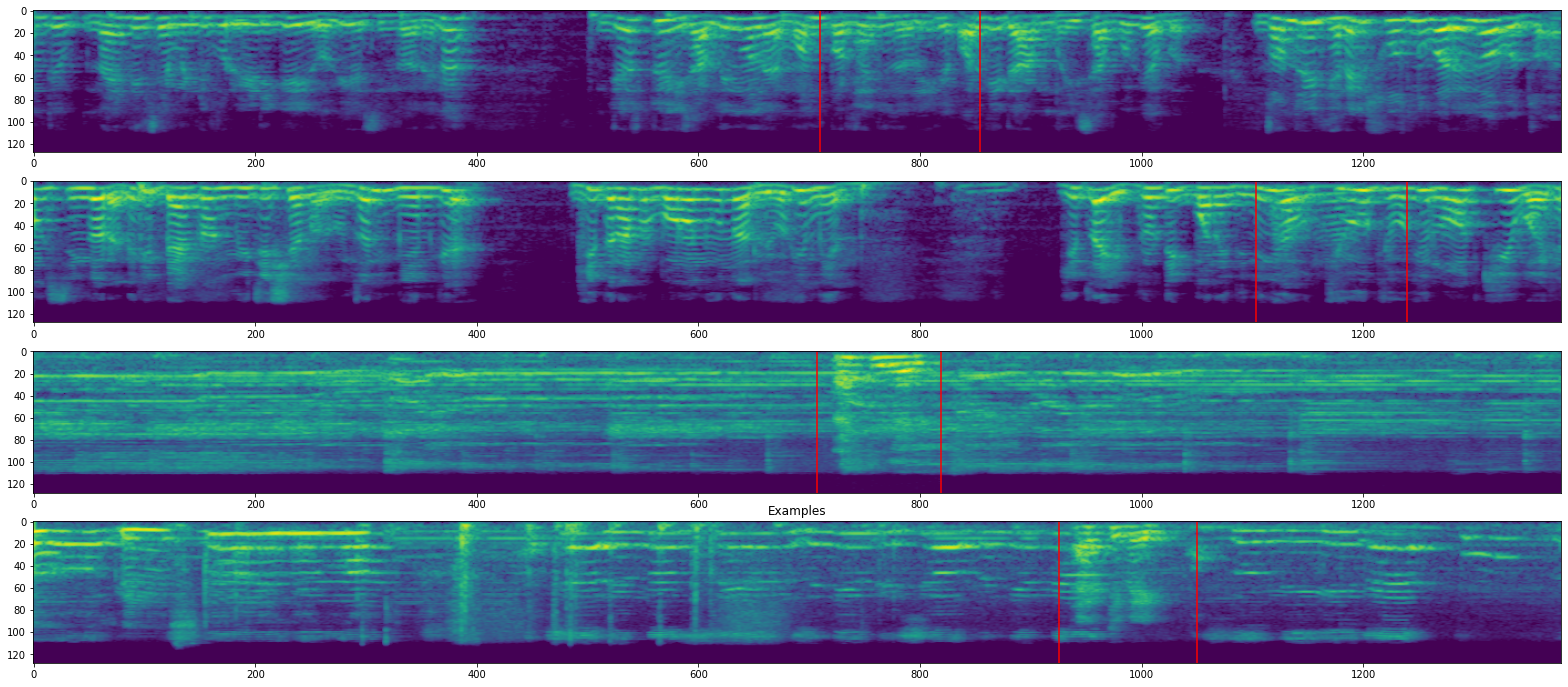

In [66]:
train_path = 'data/external/processed/train'
test_path = 'data/external/processed/test'

meta_data_train = meta_data[:1701]
meta_data_test = meta_data[1701:]

pos_examples = meta_data_train[meta_data_train.label == 1].sample(4)
neg_examples = meta_data_train[meta_data_train.label == 0].sample(4)

mel_spec_pos = [ get_melspectrogram_db( os.path.join( train_path , pos_example.filename ) , 44100  )  for _,pos_example in pos_examples.iterrows() ]
mel_spec_pos_norm = [ norm_spec(i) for i in mel_spec_pos ]

mel_spec_neg = [ get_melspectrogram_db( os.path.join( train_path , neg_example.filename ) , 44100  ) for _,neg_example in neg_examples.iterrows() ]
mel_spec_neg_norm = [ norm_spec(i) for i in mel_spec_neg ]

mel_scale_max = mel_spec_pos[0].shape[1]
time_scale_max = 8000 ## ms

potential_range_in_freq_domain = [  ( mel_scale_max * pos_example.start_time / time_scale_max , 
                                      mel_scale_max * pos_example.end_time / time_scale_max) 
                                      for _,pos_example in pos_examples.iterrows()]


plot_help.plot_examples(mel_spec_pos , potential_range_in_freq_domain  )

In [23]:
from pydub.playback import play
from pydub import AudioSegment

## Check one such example for Verification
pos_sound = AudioSegment.from_wav(os.path.join( file_path , pos_examples.iloc[2].filename ))
neg_sound = AudioSegment.from_wav(os.path.join( file_path , neg_examples.iloc[0].filename ))

def check_example(sound):

    ## playing positive example
    print('Playing ...')
    play( sound )
    print('Playing Stopped')

check_example(pos_sound)

Playing ...
Playing Stopped


## Sanity Check : Take in an audio input and take a look at spectrogram 

In [12]:
## my personal recording
import time
record = RecordThread('sample_record.wav', 8)
record.start()
time.sleep(9)
record.stoprecord()

Recording and Saving at 8 seconds Gap
Finished recording an interval 
Saving the interval


In [19]:
get_melspectrogram_db( 'inference_0.wav' , 44100  )

(128, 690)

## Working with Audio Dataloaders and Transformations

In [44]:
from torch import Tensor
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

In [49]:
meta_data[:1701].shape , meta_data[1701:].shape

((1701, 4), (299, 4))

In [72]:
class AudioLoader(Dataset):
    def __init__(self, meta_data, transform=None, mode="train"):
        # setting directories for data
        data_root = "data/external/processed"
        self.mode = mode
        if self.mode is "train":
            self.data_dir = os.path.join(data_root, "train")
            self.csv_file = meta_data[:1701]
            
        elif self.mode is "test":
            self.data_dir = os.path.join(data_root, "test")
            self.csv_file = meta_data[1701:]
        
        self.transform = transform
        
    def __len__(self):
        return self.csv_file.shape[0] 

    def __getitem__(self, idx):
        filename = self.csv_file["filename"][idx]
        file_path = os.path.join( self.data_dir, filename )

        data,sr = librosa.load(file_path,sr=44100)

        if self.transform is not None:
            data = self.transform(data)

        if self.mode is "train":
            label = self.csv_file["label"][idx]
            return data, label

        elif self.mode is "test":
            return data

In [73]:
audio_transformation = transforms.Compose([
        lambda x: x.astype(np.float32) / np.max(x), # rescale to -1 to 1
        lambda x: librosa.feature.melspectrogram(x, sr=44100, n_fft=2048,
                    hop_length=512,n_mels=128,fmin=20,fmax=8300), # MFCC 
        lambda x : librosa.power_to_db(x,top_db=80),
        lambda x : norm_spec(x),
        lambda x: Tensor(x)
        ])

In [74]:
# todo: multiprocessing, padding data
dataloader = DataLoader(
    AudioLoader(meta_data=meta_data, transform=audio_transformation, mode="train"), 
    batch_size=12,
    shuffle=True, 
    num_workers=0)

In [75]:
for index, (data, label) in enumerate(dataloader):
    print(label.numpy())
    print(data.shape)
    break

[1 0 0 1 1 0 0 0 0 1 1 0]
torch.Size([12, 128, 690])
